# Reading Noisy DAS Data.




/tmp/ipykernel_81035/182695691.py:9: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(r'../data/eq-' +str(eq) + '.mat')


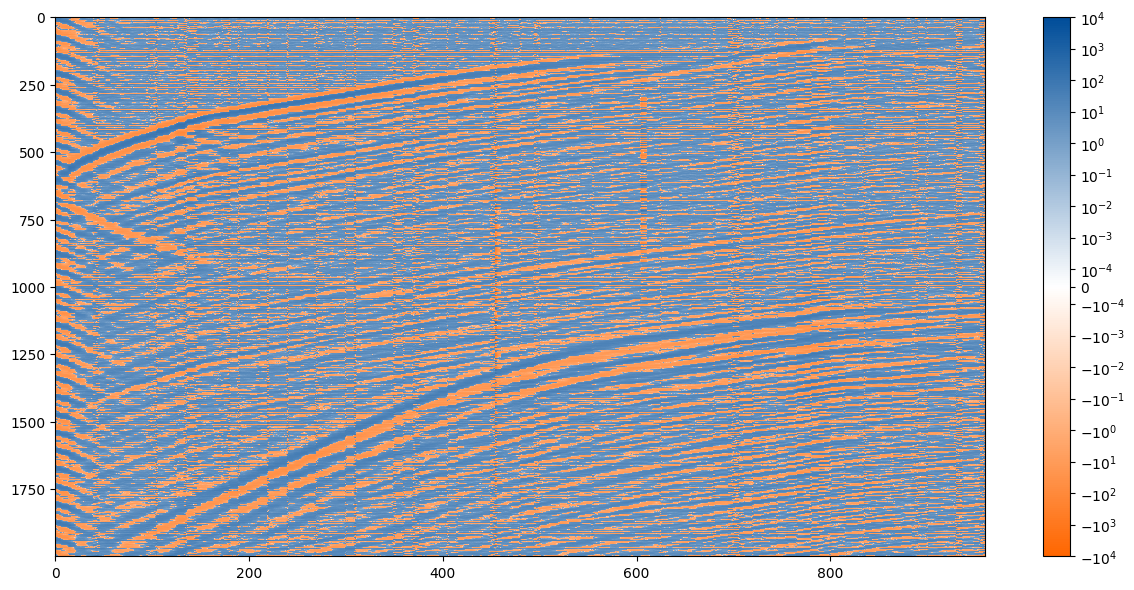

In [1]:
import numpy as np
import h5py
from matplotlib import pylab as plt
from Utils.cmap import cmaps
from matplotlib.colors import SymLogNorm

# Reading DAS data (FORGE Example).
eq = 68
f = h5py.File(r'../data/eq-' +str(eq) + '.mat')
dn = np.array(np.transpose(f.get('d1')))

#Plotting Noisy DAS Data.
plt.figure(figsize=(15,7))
plt.imshow(dn, cmap=cmaps['bluorange'], 
           norm=SymLogNorm(linthresh=1e-4, linscale=0.5, vmin=-1e4, vmax=1e4, base=10))
plt.axis('tight')
plt.colorbar();


# Preprocessing  Steps.

1- Band-pass filter (the target of the DL network).

2- Median filter (smooth step to obtain a clean CWT scale). 

3- CWT Scale (the guided data to the DL network).


In [2]:
# Preprocessing the DAS data (band-pass filter, median filter and CWT).
from Utils.bp import bandpass
from Utils.mf import mf
from Utils.fk import fkdip
import py_cwt2d

# Band-pass filter
dt = 0.0005
BP = bandpass(dn,dt,1e-3,250,6,6,0,0)
# Median Filter
BPMF = mf(BP,5,1,1)
#CWT
ss = np.arange(1,10.5,0.5) #scale
# calculate the CWT Scale.
coeffs_nsq, wav_norm_nsq = py_cwt2d.cwt_2d(BPMF, ss, 'mexh')
# Choose the Finest One (Last Scale).
CWTSCALE = np.abs(coeffs_nsq[:,:,-1])

# Train the DL Model in an Unsupervised Manner (No Lebels are Required).




In [4]:
from Utils.DLModel import *
# Set the DL Parameters
# Patch Size and Number of Shift Samples
w1 = 48
w2 = 48
s1z = 8
s2z = 8
# Set the Number of Neurons Per First Encoder Layer.
D1 = 1024
# Set the Number of Epoch and Batch Size.
epochs = 100
batch_size = 128

# Training the NEtwork in an Unsupervised Manner.
outB = Train(CWTSCALE,BP,epochs,batch_size,w1,w2,s1z,s2z,D1,eq)

# After DL Denoising, Applying the dip filter in fk.
d2 = outB - fkdip(outB,0.02)
np.save('../outputs/Denoised_eq-' + str(eq) + '.npy', d2)

2023-12-11 16:36:28.408102: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-12-11 16:36:30.230260: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-12-11 16:36:30.231233: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-12-11 16:36:30.268703: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:af:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.71GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2023-12-11 16:36:30.268733: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-12-11 16:36:30.270261: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.1

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer1 (InputLayer)       [(None, 2304, 1)]    0                                            
__________________________________________________________________________________________________
input_layer2 (InputLayer)       [(None, 2304, 1)]    0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 2304, 2)      0           input_layer1[0][0]               
                                                                 input_layer2[0][0]               
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 2304)         0           concatenate[0][0]            

2023-12-11 16:36:32.977528: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-12-11 16:36:32.994745: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2100000000 Hz


Epoch 1/100


2023-12-11 16:36:34.832817: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


221/221 [==============================] - 8s 25ms/step - loss: 7.3260 - mse: 158.9281
Epoch 2/100
221/221 [==============================] - 6s 27ms/step - loss: 6.4596 - mse: 129.0456
Epoch 3/100
221/221 [==============================] - 5s 24ms/step - loss: 6.1965 - mse: 121.6173
Epoch 4/100
221/221 [==============================] - 5s 21ms/step - loss: 5.9622 - mse: 116.3723
Epoch 5/100
221/221 [==============================] - 5s 22ms/step - loss: 5.7483 - mse: 108.7149
Epoch 6/100
221/221 [==============================] - 4s 20ms/step - loss: 5.6524 - mse: 105.8692
Epoch 7/100
221/221 [==============================] - 5s 23ms/step - loss: 5.5106 - mse: 102.4844
Epoch 8/100
221/221 [==============================] - 5s 23ms/step - loss: 5.4087 - mse: 99.9407
Epoch 9/100
221/221 [==============================] - 5s 21ms/step - loss: 5.3460 - mse: 100.6684
Epoch 10/100
221/221 [==============================] - 4s 20ms/step - loss: 5.2891 - mse: 98.5193
Epoch 11/100
221/221 [=

# Plotting the Results.


Text(0.5, 1.0, 'Remove Noise Section')

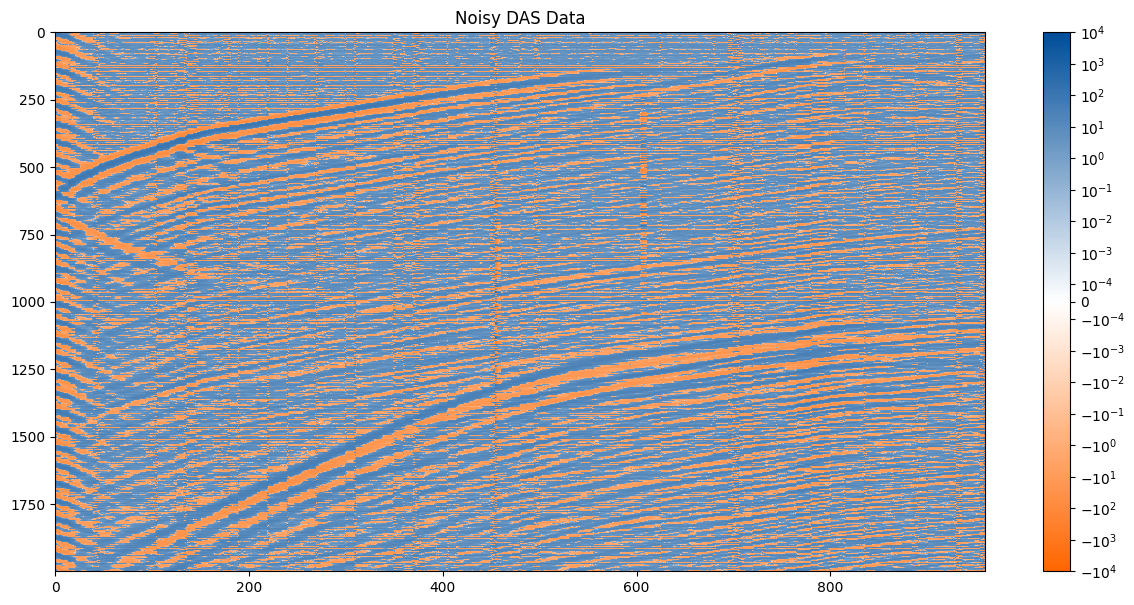

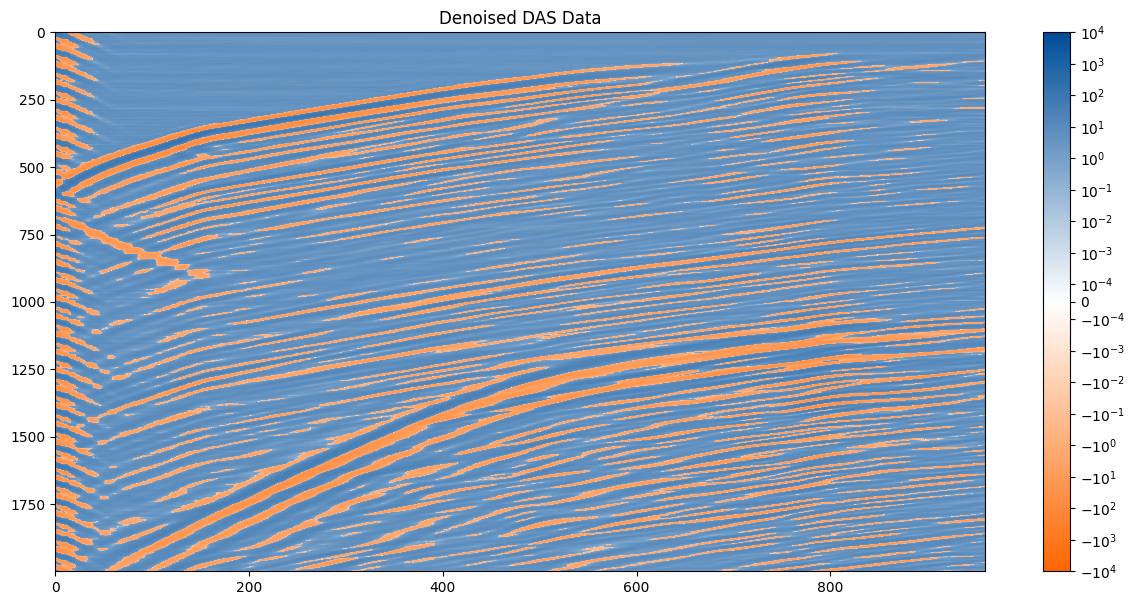

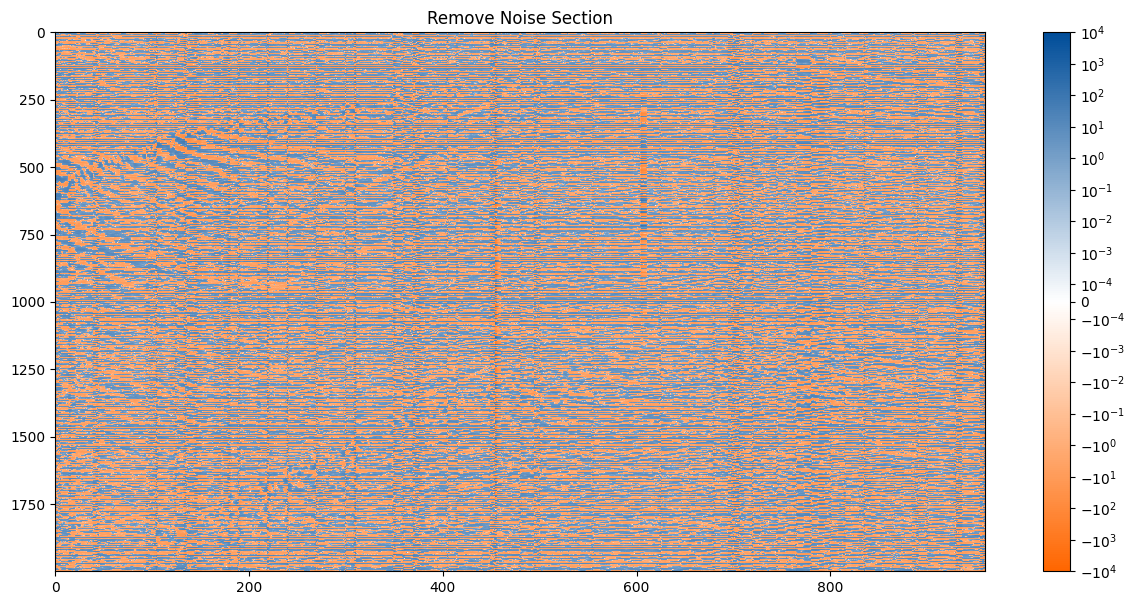

In [5]:

# Noisy DAS Data.
plt.figure(figsize=(15,7))
plt.imshow(dn, cmap=cmaps['bluorange'], 
           norm=SymLogNorm(linthresh=1e-4, linscale=0.5, vmin=-1e4, vmax=1e4, base=10))
plt.axis('tight')
plt.colorbar();
plt.title('Noisy DAS Data')


# Denoised DAS Data.
plt.figure(figsize=(15,7))
plt.imshow(d2, cmap=cmaps['bluorange'], 
           norm=SymLogNorm(linthresh=1e-4, linscale=0.5, vmin=-1e4, vmax=1e4, base=10))
plt.axis('tight')
plt.colorbar();
plt.title('Denoised DAS Data')


# Remove Noise Section.
plt.figure(figsize=(15,7))
plt.imshow(dn-d2, cmap=cmaps['bluorange'], 
           norm=SymLogNorm(linthresh=1e-4, linscale=0.5, vmin=-1e4, vmax=1e4, base=10))
plt.axis('tight')
plt.colorbar();
plt.title('Remove Noise Section')
